1500
2365
1760
1235
2523
(5, 1)


C:\Users\phili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\phili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\index_tricks.py:393: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  newobj = array(item, copy=False, subok=True, ndmin=ndmin)


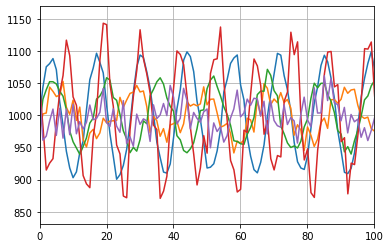

In [8]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

def load_data(file):
    mat = scipy.io.loadmat(file)
    return mat['val'][0][0]

def show_subplot(ax, y, start, stop):
    x_linspace = np.linspace(0, len(y), len(y))
    ax.set_xlim([start, stop])
    ax.plot(x_linspace, y)

def main():
    fig_subset_view, ax = plt.subplots()
    ax.grid()
    samples_matrix = np.array([])
    for i in range (5):
        file = 'heartbeat_data/00'+str(i)+'.mat'
        y = load_data(file)
        samples_matrix.append(y)
        print(len(y))
        show_subplot(ax, y, 0, 100)
    ica.fit_transform(samples_matrix.T)
    print(np.shape(S))

main()